Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. <br>
SPDX-License-Identifier: CC-BY-NC-4.0

# Simple Example (LLM)

This example shows how to prune an LLM, using a pretrained model and dataset from Hugging Face. By nature LLMs are large, so it is not possible to prune them quickly for the purposes of a demo, nor without access to a GPU (or multiple). For this reason, this example shows how to prune a tiny LLM with arbitrary weights. To prune a "real" LLM, you'll need run this code on an instance with an appropriate number of GPUs and memory, for a number of hours or days. The settings that should be changed to get the settings we used in the paper for Mistral-7B are indicated after the # sign, where a change is needed. 

Some aspects of this example are specific to LLMs, such as the loading of the model, preparation of the data, and the evaluation of the model. If your model is not an LLM, `simple_example.ipynb` may be a better starting point. 

## Language model evaluation harness

To run this example, please make sure to install the LM Evaluation Harness first:
```
git clone https://github.com/EleutherAI/lm-evaluation-harness
cd lm-evaluation-harness
pip install -e .
```

### Imports 

In [1]:
import multiprocessing

import os
import pickle
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from icbs.evaluation import evaluate_model, evaluate_model_tasks
from icbs.loops import prune_loop
from icbs.pruner import Pruner
from icbs.solvers import ConstrainedSASolver
from icbs.util import calc_density, get_log_w_names_step, get_named_weights
from icbs.util_llm import is_llm, load_llm, prep_loader_batch, prepare_llm
from util import load_dataset, set_num_threads, set_seed

### Settings

Some settings are chosen specifically so that this notebook can be run in a short time.  In such cases, the settings used for the LLMs in the paper are included after the # symbol.

In [2]:
# Model and dataset
model_name = "stas/tiny-random-llama-2"  # "mistralai/Mistral-7B-v0.1"
dataset_name = "stas/c4-en-10k"  # "allenai/c4"
dataset_args = {}  # {"streaming": True, "name": "en"}
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pruner parameters
seed = 43
density = 0.3
pruner_num_epochs = 5  # 10
num_steps_per_epoch = 1  # 300
init_method = "magnitude"  # "wanda_per_output"
block_size = 128  # 4096
num_restarts = 1  # 20
min_num_steps_per_layer = 1  # 10
selection_method = "gradient"
calc_hessian_method = "gradient_per_sample"
grad_multiplier = 0.75
ridge_multiplier = 0.001
verbose = 2

# Batch sizes
batch_size_evaluation = 64  # 1
batch_size_pruning = 16
batch_size_calibration = 64  # 128
max_batch_size = 1

# Block settings
block_solver = ConstrainedSASolver(verbose=verbose, num_restarts=num_restarts)
k = block_size // 2
tabu_frac = 0.40
fix_frac_prune = 0.42
fix_frac_keep = 0.35

# Workers, etc.
num_cpus = multiprocessing.cpu_count()
dataloader_args = {
    "num_workers": 4 if torch.cuda.is_available() else 0,
    "pin_memory": False,
}

# Only prune linear layers and do not prune the final layer
keep_layers = (torch.nn.Linear,)
layer_name_to_exclude = "lm_head"

# The loss function
loss_function = nn.CrossEntropyLoss()

# Evaluation
evaluate_model_tasks_args = {
    "tasks": ["hellaswag"],
    # ["boolq", "rte", "hellaswag", "winogrande", "arc_easy", "arc_challenge", "openbookqa"]
    "num_fewshot": 0,  # This is zero-shot evaluation
    "limit": 10,  # None
    "check_integrity": False,
    "use_cache": None,  # Do not cache model responses
    "random_seed": None,  # Do not set random seeds - we handle that already
    "numpy_random_seed": None,
    "torch_random_seed": None,
    "fewshot_random_seed": None,
}

# Set the number of threads and seed the random number generator
set_num_threads(num_cpus)
set_seed(seed)

## Load a model

When running on a machine with multiple GPUs, the print out below this cell will show the distribution of the model across GPUs. 

In [3]:
# Load a fresh model
# Note: it's important to load the model before getting a reference
# to the weights (below)
model = load_llm(model_name, device)
model, tokenizer, seqlen, input_device = prepare_llm(model, device)

Device map: {'': device(type='cpu')}


Choose which layer to prune at each step. 

In [4]:
# The list of layers to process
named_weights = get_named_weights(model, keep_layers)
named_weights = {
    name: weights
    for name, weights in named_weights.items()
    if layer_name_to_exclude not in name
}
layer_names = list(named_weights.keys())
print(f"Pruning {len(layer_names)} layers")

# The distribution of steps to weights
w_names_step = get_log_w_names_step(
    named_weights, num_steps_per_epoch, min_num_steps_per_layer
)

Pruning 14 layers


## Load a dataset

Now, let's load the dataset:

In [5]:
train_dataset, valid_dataset = load_dataset(dataset_name, **dataset_args)

Then we set up data loaders for pruning and validation:

In [6]:
# Pruning dataloader
prune_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size_pruning,
    shuffle=False,
    **dataloader_args,
)
prune_dataloader.tokenizer = tokenizer  # Inject tokenizer to allow downstream use

# Data loader
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size_evaluation,
    shuffle=False,
    **dataloader_args,
)
valid_dataloader.tokenizer = tokenizer  # Inject tokenizer

If the initial selection of weights to prune is done using Wanda or the Gradient option, then we also need to provide the calibaration data:

In [7]:
if init_method.startswith("wanda") or init_method.startswith("gradient"):
    calibration_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size_calibration,
        shuffle=False,  # Set to True for any dataset that is not streamed
        **dataloader_args,
    )
    calibration_dataloader.tokenizer = tokenizer  # Inject tokenizer
    calibration_loader_batch = next(iter(calibration_dataloader))
    X_init, y_init = prep_loader_batch(calibration_loader_batch, tokenizer, seqlen)
else:
    X_init, y_init = None, None

## Evaluate the model (before pruning)

We check the performance of the model before pruning, as a point of reference: 

In [8]:
print("Evaluating model before pruning:")
unpruned_evaluation_start_time = time.time()
unpruned_valid_accuracy, unpruned_evaluation_time, _ = evaluate_model_tasks(
    model=model,
    tokenizer=tokenizer,
    verbose=True if verbose else False,
    batch_size=batch_size_evaluation,
    device=device,
    **evaluate_model_tasks_args,
)
unpruned_evaluation_time = time.time() - unpruned_evaluation_start_time
print(f"Initial evaluation took: {unpruned_evaluation_time/60:.2f}min")

2024-11-05:17:11:09,070 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:11:09,071 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:11:09,073 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:11:09,076 INFO     [evaluator.py:217] Using pre-initialized model


Evaluating model before pruning:


2024-11-05:17:11:09,822 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:11:12,873 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:11:25,266 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:11:35,818 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:11:35,820 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:11:35,821 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1775.22it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=31.3sec, Accuracy: 30.00% (+-15.28%)
Initial evaluation took: 0.52min


## Run 

For demonstration purposes, the below will even run on a CPU and should take a few minutes (depending on the specs). However, we recommend running any actual experiments on a machine with at least one GPU. First we instantiate the pruner, which will already perform the initial pruning:

In [9]:
initial_pruning_start_time = time.time()

print("*" * 80)
print(
    f"Pruning weights across all layers using {density=} "
    f"block_solver={block_solver.__class__.__name__} "
    f"{block_size=} {k=} {init_method=} {selection_method=} "
    f"{grad_multiplier=} {ridge_multiplier=} {calc_hessian_method=} "
    f"{seed=} {tabu_frac=} {fix_frac_prune=} {fix_frac_keep=} \n"
)

pruner = Pruner(
    model,
    loss_function,
    density,
    block_solver,
    block_size,
    k,
    layer_names,
    init_method,
    selection_method,
    grad_multiplier,
    ridge_multiplier,
    calc_hessian_method,
    seed,
    verbose,
    X_init=X_init,
    y_init=y_init,
    tabu_frac=tabu_frac,
    fix_frac_prune=fix_frac_prune,
    fix_frac_keep=fix_frac_keep,
    max_batch_size=max_batch_size,
)

print(f"Target density: {density} Actual density: {calc_density(model):.4f}")

print("Evaluating model after initial pruning:")
valid_accuracy, evaluation_time, _ = evaluate_model_tasks(
    model=model,
    tokenizer=tokenizer,
    verbose=True if verbose else False,
    batch_size=batch_size_evaluation,
    device=device,
    **evaluate_model_tasks_args,
)

initial_pruning_time = time.time() - initial_pruning_start_time
print(f"Initial pruning and validation took: {initial_pruning_time/60:.2f}min")

********************************************************************************
Pruning weights across all layers using density=0.3 block_solver=ConstrainedSASolver block_size=128 k=64 init_method='magnitude' selection_method='gradient' grad_multiplier=0.75 ridge_multiplier=0.001 calc_hessian_method='gradient_per_sample' seed=43 tabu_frac=0.4 fix_frac_prune=0.42 fix_frac_keep=0.35 

Resetting pruner
Performing initial pruning on layer model.layers.0.self_attn.q_proj.weight
w_name='model.layers.0.self_attn.q_proj.weight', num_weights=256, self.density=0.3, num_fix_keep=27, num_fix_prune=75


2024-11-05:17:11:40,612 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:11:40,613 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:11:40,615 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:11:40,617 INFO     [evaluator.py:217] Using pre-initialized model


Layer model.layers.0.self_attn.q_proj.weight cannot support tabu list of size 62 (tabu fraction 0.4 * num candidate weights 154), given block size 128. Switching off tabu for this layer.
Done with initial pruning of layer model.layers.0.self_attn.q_proj.weight, layer_density=0.301
    _perform_init_pruning_layer() took: 0.01s
Performing initial pruning on layer model.layers.0.self_attn.k_proj.weight
w_name='model.layers.0.self_attn.k_proj.weight', num_weights=256, self.density=0.3, num_fix_keep=27, num_fix_prune=75
Layer model.layers.0.self_attn.k_proj.weight cannot support tabu list of size 62 (tabu fraction 0.4 * num candidate weights 154), given block size 128. Switching off tabu for this layer.
Done with initial pruning of layer model.layers.0.self_attn.k_proj.weight, layer_density=0.301
    _perform_init_pruning_layer() took: 0.00s
Performing initial pruning on layer model.layers.0.self_attn.v_proj.weight
w_name='model.layers.0.self_attn.v_proj.weight', num_weights=256, self.densi

2024-11-05:17:11:41,387 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:11:44,774 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:11:56,233 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:12:05,293 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:12:05,295 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:12:05,296 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1813.91it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=27.4sec, Accuracy: 30.00% (+-15.28%)
Initial pruning and validation took: 0.46min


Then we run the optimization-based pruning steps to (hopefully) improve on the initial pruning:

In [10]:
experiment_start_time = time.time()

valid_accuracies = [valid_accuracy]
prune_times = [0.0]
evaluation_times = [evaluation_time]
for num_epoch in range(1, pruner_num_epochs + 1):
    print("-" * 80)
    print(f"{num_epoch=}")
    start_time = time.time()
    w_names_step = np.random.permutation(w_names_step)
    prune_loop(
        prune_dataloader,
        model,
        pruner,
        input_device,
        w_names_step,
        verbose=1 if verbose else None,
    )
    prune_time = time.time() - start_time

    print(f"\nEvaluating model after epoch {num_epoch}:")
    valid_accuracy, evaluation_time, _ = evaluate_model_tasks(
        model=model,
        tokenizer=tokenizer,
        verbose=True if verbose else False,
        batch_size=batch_size_evaluation,
        device=device,
        **evaluate_model_tasks_args,
    )
    print(f"  Time: {prune_time=:.1f}sec\n")

    valid_accuracies.append(valid_accuracy)
    prune_times.append(prune_time)
    evaluation_times.append(evaluation_time)

experiment_time = time.time() - experiment_start_time
print(f"Experiment took: {experiment_time/60:.2f}min")

--------------------------------------------------------------------------------
num_epoch=1
-----------------------
Pruner step 1 (of 1)


2024-11-05:17:12:27,837 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:12:27,838 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:12:27,840 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:12:27,842 INFO     [evaluator.py:217] Using pre-initialized model


    Calculated gradient in 19.56s
    w_name='model.layers.0.mlp.gate_proj.weight' k_effective=64
    _calc_grad_sample_block() took: 0.00s
    _calc_hess_block() took: 0.00s
    scaling=3.010e+07 cutoff=1.000e-12 Q_density=1.00000 Q_density_cutoff=0.50421
    Solving with ConstrainedSASolver, problem_filename=PosixPath('.98345_241105_171227700923_57a693665e14481e9497a184ecf6d291.tmp')
    n=128 best_E=314.115 elapsed_time=0.018
    dL=-0.000 dE=-0.000 ridge_contribution=0.000 const=-0.000 best_E=0.000 dL_eval=-0.000 delta_w_squared=0.033
    Pruner step took: 19.76s

Evaluating model after epoch 1:


2024-11-05:17:12:28,496 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:12:31,245 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:12:41,298 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:12:48,601 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:12:48,603 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:12:48,604 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1924.88it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=23.5sec, Accuracy: 30.00% (+-15.28%)
  Time: prune_time=19.8sec

--------------------------------------------------------------------------------
num_epoch=2
-----------------------
Pruner step 1 (of 1)


2024-11-05:17:13:09,934 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:13:09,936 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:13:09,938 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:13:09,940 INFO     [evaluator.py:217] Using pre-initialized model


    Calculated gradient in 18.46s
    w_name='model.layers.0.mlp.gate_proj.weight' k_effective=64
    _calc_grad_sample_block() took: 0.00s
    _calc_hess_block() took: 0.00s
    scaling=4.510e+07 cutoff=1.000e-12 Q_density=1.00000 Q_density_cutoff=0.49719
    Solving with ConstrainedSASolver, problem_filename=PosixPath('.98345_241105_171309817864_ac4e910e0f344588867ae1aa335b84c7.tmp')
    n=128 best_E=205.037 elapsed_time=0.014
    dL=-0.000 dE=0.000 ridge_contribution=0.000 const=0.000 best_E=0.000 dL_eval=-0.000 delta_w_squared=0.028
    Pruner step took: 18.61s

Evaluating model after epoch 2:


2024-11-05:17:13:10,582 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:13:13,400 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:13:23,459 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:13:31,202 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:13:31,204 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:13:31,205 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1902.96it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=23.9sec, Accuracy: 30.00% (+-15.28%)
  Time: prune_time=18.6sec

--------------------------------------------------------------------------------
num_epoch=3
-----------------------
Pruner step 1 (of 1)


2024-11-05:17:13:53,157 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:13:53,159 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:13:53,161 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:13:53,163 INFO     [evaluator.py:217] Using pre-initialized model


    Calculated gradient in 19.17s
    w_name='model.layers.0.mlp.gate_proj.weight' k_effective=64
    _calc_grad_sample_block() took: 0.00s
    _calc_hess_block() took: 0.00s
    scaling=2.565e+07 cutoff=1.000e-12 Q_density=1.00000 Q_density_cutoff=0.50568
    Solving with ConstrainedSASolver, problem_filename=PosixPath('.98345_241105_171353028294_d48ee326d9cf43b1a07c14933ba77c5d.tmp')
    n=128 best_E=1.745 elapsed_time=0.025
    dL=0.000 dE=0.000 ridge_contribution=0.000 const=0.000 best_E=0.000 dL_eval=-0.000 delta_w_squared=0.027
    Pruner step took: 19.34s

Evaluating model after epoch 3:


2024-11-05:17:13:53,921 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:13:56,645 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:14:06,778 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:14:15,465 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:14:15,467 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:14:15,468 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1661.70it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=25.2sec, Accuracy: 30.00% (+-15.28%)
  Time: prune_time=19.3sec

--------------------------------------------------------------------------------
num_epoch=4
-----------------------
Pruner step 1 (of 1)


2024-11-05:17:14:36,935 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:14:36,936 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:14:36,938 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:14:36,940 INFO     [evaluator.py:217] Using pre-initialized model


    Calculated gradient in 18.43s
    w_name='model.layers.0.mlp.gate_proj.weight' k_effective=64
    _calc_grad_sample_block() took: 0.00s
    _calc_hess_block() took: 0.00s
    scaling=3.266e+07 cutoff=1.000e-12 Q_density=1.00000 Q_density_cutoff=0.54718
    Solving with ConstrainedSASolver, problem_filename=PosixPath('.98345_241105_171436815142_f540d2661b6e42e28ac6a558714991b5.tmp')
    n=128 best_E=731.490 elapsed_time=0.013
    dL=0.000 dE=0.000 ridge_contribution=0.000 const=0.000 best_E=0.000 dL_eval=-0.000 delta_w_squared=0.005
    Pruner step took: 18.58s

Evaluating model after epoch 4:


2024-11-05:17:14:37,581 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:14:40,339 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:14:50,521 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:14:58,284 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:14:58,285 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:14:58,286 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1475.36it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=24.3sec, Accuracy: 30.00% (+-15.28%)
  Time: prune_time=18.6sec

--------------------------------------------------------------------------------
num_epoch=5
-----------------------
Pruner step 1 (of 1)


2024-11-05:17:15:20,732 WARNING  [huggingface.py:96] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-11-05:17:15:20,735 INFO     [huggingface.py:483] Using model type 'default'
2024-11-05:17:15:20,737 WARNING  [huggingface.py:277] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-11-05:17:15:20,740 INFO     [evaluator.py:217] Using pre-initialized model


    Calculated gradient in 19.35s
    w_name='model.layers.0.mlp.gate_proj.weight' k_effective=64
    _calc_grad_sample_block() took: 0.00s
    _calc_hess_block() took: 0.00s
    scaling=3.791e+07 cutoff=1.000e-12 Q_density=1.00000 Q_density_cutoff=0.49567
    Solving with ConstrainedSASolver, problem_filename=PosixPath('.98345_241105_171520600940_233291fc4d684397aade90084cb7c5ed.tmp')
    n=128 best_E=50.679 elapsed_time=0.014
    dL=0.000 dE=0.000 ridge_contribution=0.000 const=0.000 best_E=0.000 dL_eval=-0.000 delta_w_squared=0.001
    Pruner step took: 19.51s

Evaluating model after epoch 5:


2024-11-05:17:15:21,477 DEBUG    [__init__.py:522] File _phrases_va_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/catalan_bench/phrases_va could not be loaded
2024-11-05:17:15:24,217 DEBUG    [__init__.py:522] File _phrases_es_common.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/spanish_bench/phrases_es could not be loaded
2024-11-05:17:15:34,404 DEBUG    [__init__.py:522] File winogenerated.yaml in /Users/gilir/git/pruning-nns/lm-evaluation-harness/lm_eval/tasks/model_written_evals/winogenerated could not be loaded
2024-11-05:17:15:43,621 WARNING  [evaluator.py:270] Overwriting default num_fewshot of hellaswag from None to 0
2024-11-05:17:15:43,623 DEBUG    [cache.py:33] requests-hellaswag-0shot-rank0-world_size1-tokenizer is not cached, generating...
2024-11-05:17:15:43,624 INFO     [task.py:415] Building contexts for hellaswag on rank 0...
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1784.73it/s]
202

Results for each task:
    hellaswag : 30.000 (+-15.275)
  Evaluation time: evaluation_time=25.7sec, Accuracy: 30.00% (+-15.28%)
  Time: prune_time=19.5sec

Experiment took: 3.64min


## Plot the results

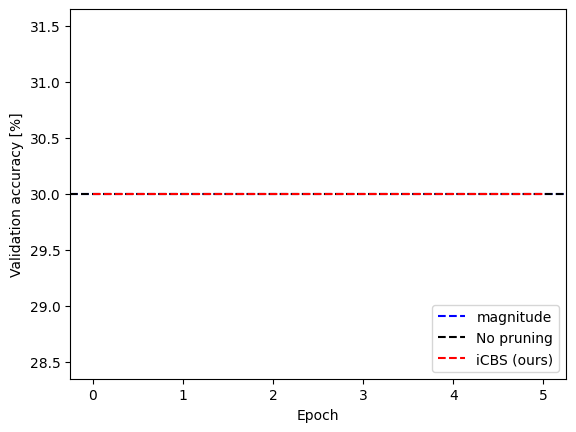

In [11]:
# Plot the evolution of the validation accuracy across epochs
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy [%]")
plt.axhline(y=valid_accuracies[0], linestyle="--", label=f"{init_method}", color="b")
plt.axhline(y=unpruned_valid_accuracy, linestyle="--", label=f"No pruning", color="k")
plt.plot(valid_accuracies, label="iCBS (ours)", linestyle="--", color="r")
plt.legend(loc="lower right");